### Assignment 1 (4 scores):

- Use Numpy only to construct the Logistic Regression model.
- Train that Logistic Regression model dataset using the Gradient Descend approach on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset. *Note that three class in this dataset must be merge into two class as: graduate and non-graduate (dropout or enroll)*.
- Evaluate that Logistic Regression model on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.
- Visualize the loss function of the training process.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [9]:
DATA_PATH = "data.csv"
df = pd.read_csv(DATA_PATH, delimiter=';', encoding='utf-8', low_memory=False)

print(df.shape)
print(df.columns.tolist())
df.head()

(4424, 37)
['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP', 'Target']


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [10]:
print(df["Target"].unique())

# Graduate -> 1, Dropout hoặc Enrolled -> 0
def map_label(x):
    s = str(x).lower()
    if 'gradu' in s:
        return 1
    return 0

y = df["Target"].apply(map_label).values

['Dropout' 'Graduate' 'Enrolled']


In [11]:
X_df = df.drop(columns=["Target"])

num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_df.columns if c not in num_cols]

if len(cat_cols) > 0:
    X_df = pd.get_dummies(X_df, columns=cat_cols, drop_first=True)

X = X_df.select_dtypes(include=[np.number]).values
print(X.shape)

if np.isnan(X).any():
    col_means = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_means, inds[1])

mu = X.mean(axis=0)
sigma = X.std(axis=0)
sigma[sigma == 0] = 1
X = (X - mu) / sigma

X = np.hstack([np.ones((X.shape[0], 1)), X])

print(X.shape)

(4424, 36)
(4424, 37)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape)
print(X_test.shape)
print(y_train.mean())


(3539, 37)
(885, 37)
0.4992935857586889


In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss_and_grad(w, Xb, yb, l2=0.0):
    m = Xb.shape[0]
    z = Xb.dot(w)
    p = sigmoid(z)
    eps = 1e-12
    loss = - (yb * np.log(p + eps) + (1 - yb) * np.log(1 - p + eps)).mean()
    if l2 > 0:
        loss += 0.5 * l2 * np.sum(w[1:]**2) / m
    grad = (Xb.T.dot(p - yb)) / m
    if l2 > 0:
        reg = np.concatenate([[0.0], l2 * w[1:] / m])
        grad += reg
    return loss, grad

LR = 0.1
EPOCHS = 1000
BATCH_SIZE = 64
L2 = 0.0

w = np.zeros(X_train.shape[1])
loss_history = []

for epoch in range(EPOCHS):
    perm = np.random.permutation(len(X_train))
    Xs = X_train[perm]
    ys = y_train[perm]
    epoch_loss = 0
    batches = int(np.ceil(len(Xs) / BATCH_SIZE))
    for i in range(batches):
        start, end = i * BATCH_SIZE, min((i+1) * BATCH_SIZE, len(Xs))
        Xb, yb = Xs[start:end], ys[start:end]
        loss, grad = compute_loss_and_grad(w, Xb, yb, L2)
        w -= LR * grad
        epoch_loss += loss * (end - start)
    epoch_loss /= len(Xs)
    loss_history.append(epoch_loss)
    if (epoch + 1) % (EPOCHS // 10 if EPOCHS >= 10 else 1) == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.6f}")


Epoch 100/1000 - Loss: 0.324490
Epoch 200/1000 - Loss: 0.324910
Epoch 300/1000 - Loss: 0.324953
Epoch 400/1000 - Loss: 0.325004
Epoch 500/1000 - Loss: 0.325196
Epoch 600/1000 - Loss: 0.324620
Epoch 700/1000 - Loss: 0.325109
Epoch 800/1000 - Loss: 0.325009
Epoch 900/1000 - Loss: 0.325195
Epoch 1000/1000 - Loss: 0.324539


Accuracy: 0.8259887005649718
Confusion Matrix:
 [[342 101]
 [ 53 389]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8658    0.7720    0.8162       443
           1     0.7939    0.8801    0.8348       442

    accuracy                         0.8260       885
   macro avg     0.8299    0.8260    0.8255       885
weighted avg     0.8299    0.8260    0.8255       885

ROC AUC: 0.9005444164121631


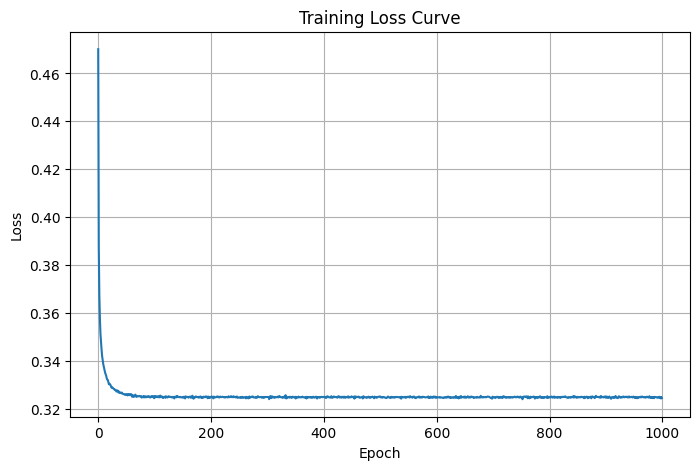

In [15]:
def predict_proba(Xb, w):
    return sigmoid(Xb.dot(w))

def predict(Xb, w, threshold=0.5):
    return (predict_proba(Xb, w) >= threshold).astype(int)

# Dự đoán
y_pred = predict(X_test, w)
y_prob = predict_proba(X_test, w)

# Đánh giá
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
try:
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except:
    pass

# Vẽ Loss
plt.figure(figsize=(8,5))
plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### Assignment 2 (4 scores):

- Use Numpy only to construct the Sofmax Regression model.
- Train that Logistic Regression model dataset using the Gradient Descend approach on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.
- Evaluate that Logistic Regression model on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.
- Visualize the loss function of the training process.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [17]:
DATA_PATH = "data.csv"
df = pd.read_csv(DATA_PATH, delimiter=';', encoding='utf-8', low_memory=False)

df.head()

,Maarital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [18]:
print(df["Target"].value_counts())

label_map = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
df["Target"] = df["Target"].map(label_map)

y = df["Target"].values
print("Unique labels:", np.unique(y))

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64
Unique labels: [0 1 2]


In [19]:
X_df = df.drop(columns=["Target"])

num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_df.columns if c not in num_cols]

if len(cat_cols) > 0:
    X_df = pd.get_dummies(X_df, columns=cat_cols, drop_first=True)

X = X_df.values

if np.isnan(X).any():
    col_means = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_means, inds[1])

mu, sigma = X.mean(axis=0), X.std(axis=0)
sigma[sigma == 0] = 1
X = (X - mu) / sigma

X = np.hstack([np.ones((X.shape[0], 1)), X])

print(X.shape)

(4424, 37)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape)
print(X_test.shape)
print(np.bincount(y_train))


(3539, 37)
(885, 37)
[1137  635 1767]


In [21]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def one_hot(y, num_classes):
    m = len(y)
    Y = np.zeros((m, num_classes))
    Y[np.arange(m), y] = 1
    return Y

def compute_loss_and_grad(W, Xb, Yb, l2=0.0):
    m = Xb.shape[0]
    logits = Xb.dot(W)
    probs = softmax(logits)
    loss = -np.sum(Yb * np.log(probs + 1e-12)) / m
    if l2 > 0:
        loss += 0.5 * l2 * np.sum(W[1:]**2) / m
    grad = (Xb.T.dot(probs - Yb)) / m
    if l2 > 0:
        grad[1:] += l2 * W[1:] / m
    return loss, grad

In [22]:
num_classes = len(np.unique(y_train))
W = np.zeros((X_train.shape[1], num_classes))
Y_train_oh = one_hot(y_train, num_classes)

LR = 0.1
EPOCHS = 1000
BATCH_SIZE = 64
L2 = 0.0

loss_history = []

for epoch in range(EPOCHS):
    perm = np.random.permutation(len(X_train))
    Xs, Ys = X_train[perm], Y_train_oh[perm]
    epoch_loss = 0
    batches = int(np.ceil(len(Xs) / BATCH_SIZE))
    for i in range(batches):
        start, end = i * BATCH_SIZE, min((i + 1) * BATCH_SIZE, len(Xs))
        Xb, Yb = Xs[start:end], Ys[start:end]
        loss, grad = compute_loss_and_grad(W, Xb, Yb, L2)
        W -= LR * grad
        epoch_loss += loss * (end - start)
    epoch_loss /= len(Xs)
    loss_history.append(epoch_loss)
    if (epoch + 1) % (EPOCHS // 10 if EPOCHS >= 10 else 1) == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.6f}")


Epoch 100/1000 - Loss: 0.561653
Epoch 200/1000 - Loss: 0.562023
Epoch 300/1000 - Loss: 0.561157
Epoch 400/1000 - Loss: 0.561748
Epoch 500/1000 - Loss: 0.561367
Epoch 600/1000 - Loss: 0.561724
Epoch 700/1000 - Loss: 0.561635
Epoch 800/1000 - Loss: 0.561372
Epoch 900/1000 - Loss: 0.561946
Epoch 1000/1000 - Loss: 0.561951


Accuracy: 0.7627118644067796
Confusion Matrix:
 [[217  27  40]
 [ 41  50  68]
 [ 14  20 408]]
Classification Report:
               precision    recall  f1-score   support

           0     0.7978    0.7641    0.7806       284
           1     0.5155    0.3145    0.3906       159
           2     0.7907    0.9231    0.8518       442

    accuracy                         0.7627       885
   macro avg     0.7013    0.6672    0.6743       885
weighted avg     0.7435    0.7627    0.7461       885



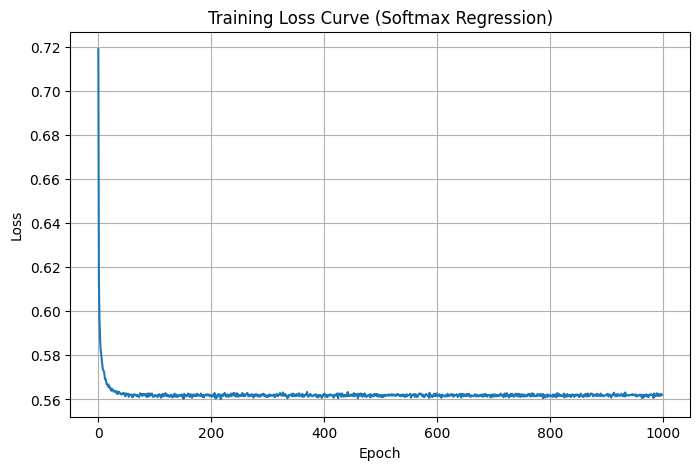

In [23]:
def predict(Xb, W):
    probs = softmax(Xb.dot(W))
    return np.argmax(probs, axis=1)

# Dự đoán
y_pred = predict(X_test, W)

# Đánh giá
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# Vẽ loss
plt.figure(figsize=(8,5))
plt.plot(loss_history)
plt.title("Training Loss Curve (Softmax Regression)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### Assignment 3 (2 scores):

- Use a Machine Learning library (Scikit Learn or Skorch) to implement and evaluate the Logistic Regression on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.
- Use a Machine Learning library (Scikit Learn or Skorch) to implement and evaluate the Softmax Regression on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

df = pd.read_csv("data.csv", delimiter=";", encoding="utf-8")

print(df.shape)
df.head()

(4424, 37)


,Maarital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [25]:
df["Target"] = df["Target"].replace({
    "Dropout": 0,
    "Enrolled": 1,
    "Graduate": 2
})

X = df.drop(columns=["Target"])
y = df["Target"]

X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

C:\Users\light\AppData\Local\Temp\ipykernel_19588\3172646894.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Target"] = df["Target"].replace({


In [26]:
y_binary = np.where(y == 2, 1, 0)  # 1: Graduate, 0: Dropout hoặc Enrolled

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')

log_reg.fit(X_train_b, y_train_b)

y_pred_b = log_reg.predict(X_test_b)

print("Accuracy (Binary Logistic Regression):", accuracy_score(y_test_b, y_pred_b))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_b, y_pred_b))
print("\nClassification Report:")
print(classification_report(y_test_b, y_pred_b))

Accuracy (Binary Logistic Regression): 0.8259887005649718

Confusion Matrix:
[[341 102]
 [ 52 390]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       443
           1       0.79      0.88      0.84       442

    accuracy                           0.83       885
   macro avg       0.83      0.83      0.83       885
weighted avg       0.83      0.83      0.83       885



In [27]:
softmax_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')

softmax_reg.fit(X_train, y_train)

y_pred = softmax_reg.predict(X_test)

print("Accuracy (Softmax Regression):", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy (Softmax Regression): 0.768361581920904

Confusion Matrix:
[[218  29  37]
 [ 43  53  63]
 [ 14  19 409]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       284
           1       0.52      0.33      0.41       159
           2       0.80      0.93      0.86       442

    accuracy                           0.77       885
   macro avg       0.71      0.68      0.68       885
weighted avg       0.75      0.77      0.75       885



c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


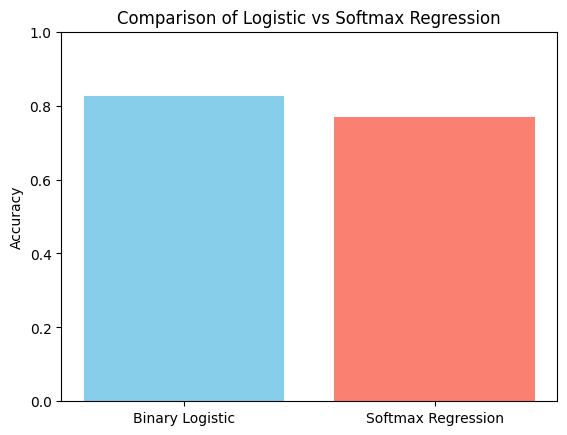

In [28]:
models = ['Binary Logistic', 'Softmax Regression']
accuracies = [
    accuracy_score(y_test_b, y_pred_b),
    accuracy_score(y_test, y_pred)
]

plt.bar(models, accuracies, color=['skyblue', 'salmon'])
plt.ylabel("Accuracy")
plt.title("Comparison of Logistic vs Softmax Regression")
plt.ylim(0, 1)
plt.show()